Enter the model to use (SVR, XGB, GBR, LSTM):  xgb
Enter the frequency (daily, weekly, monthly, quarterly):  weekly
Enter the number of periods:  12


Shapes:
predictions: (12,)
upper_bound: (12,)
lower_bound: (12,)


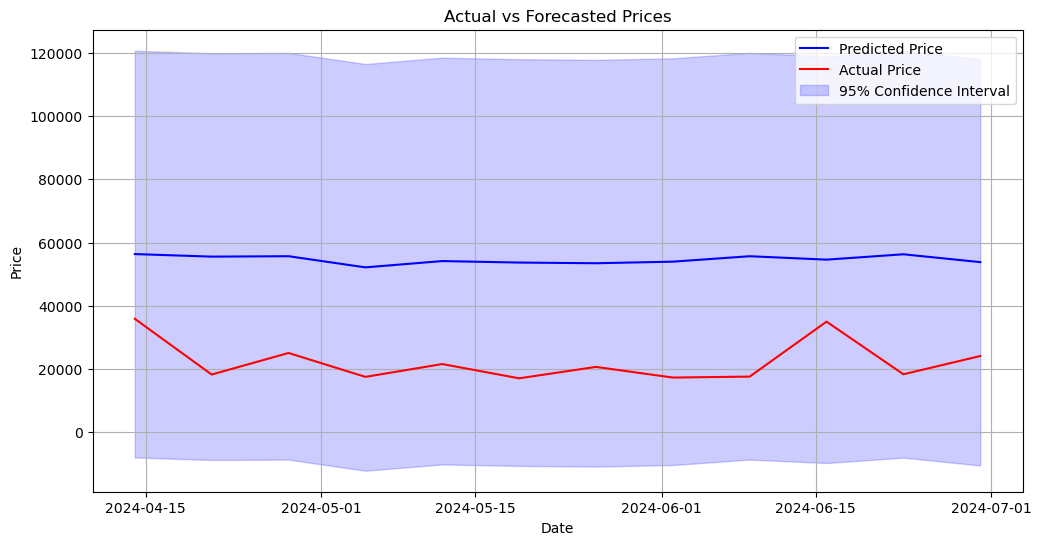

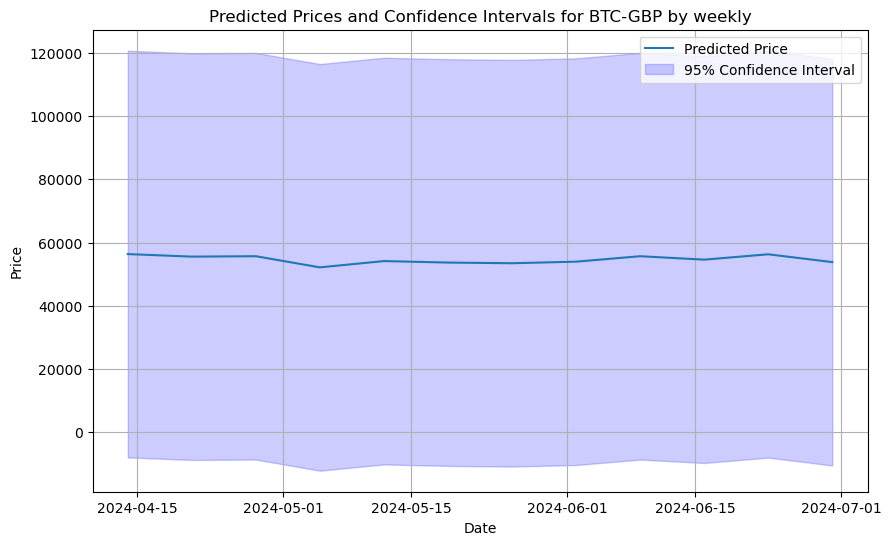

In [4]:
# doings


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import joblib
import os
import tensorflow as tf

# Function to evaluate different models for the first coin price prediction
def evaluate_models_coin_2(selected_data):
    coin_name = selected_data.columns[1]  # Dynamically get the name of the first column
    # Add lagged features for 1 to 3 days
    for lag in range(1, 4):
        selected_data.loc[:, f'{coin_name}_lag_{lag}'] = selected_data[coin_name].shift(lag)

    # Drop rows with NaN values created due to shifting
    selected_data.dropna(inplace=True)

    # Features will be the lagged values, and the target will be the current price of the first coin
    features = [f'{coin_name}_lag_{lag}' for lag in range(1, 4)]
    X = selected_data[features]
    y = selected_data[coin_name]

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize dictionary to hold models
    models = {
        'GBR': GradientBoostingRegressor(),
        'SVR': SVR(),
        'XGB': XGBRegressor(),  # Alias for XGBoost
        'LSTM': Sequential([LSTM(units=50, input_shape=(X_train.shape[1], 1)), Dense(units=1)])
    }
    # Load pre-trained models for SVR, XGBoost, and Gradient Boosting
    for model_name in ['SVR', 'XGBoost', 'Gradient Boosting']:
        model_filename = f"Model_SELECTED_COIN_2/{model_name.lower().replace(' ', '_')}_model.pkl"
        if os.path.exists(model_filename):
            models[model_name] = joblib.load(model_filename)
        else:
            print(f"No pre-trained model found for {model_name}. Skipping...")

    # User input for selecting the model
    model_choice = input("Enter the model to use (SVR, XGB, GBR, LSTM): ").upper()

    # Initialize and train the selected model
    if model_choice in models:
        model = models[model_choice]
        if model_choice != 'LSTM':
            model.fit(X_train, y_train)
    elif model_choice == 'LSTM':
        model_filename = "Model_SELECTED_COIN_2/lstm_model.pkl"
        if os.path.exists(model_filename):
            model = tf.keras.models.load_model(model_filename)
            # Reshape the input data for LSTM model
            X_test_array = X_test.to_numpy().reshape(X_test.shape[0], X_test.shape[1], 1)
            predictions = model.predict(X_test_array).flatten()
        else:
            print("No pre-trained LSTM model found.")
            return None, None, None, None
    else:
        print("Invalid model choice. Please choose from SVR, XGB, GBR, or LSTM.")
        return None, None, None, None

    return model, selected_data, X_test, y_test

# Function to plot predictions and confidence intervals
def plot_predictions(model, selected_data, X_test, y_test):
    if model is not None:
        # User input for frequency and number of periods (weeks, months, or quarters)
        frequency = input("Enter the frequency (daily, weekly, monthly, quarterly): ").lower()
        num_periods = int(input("Enter the number of periods: "))

        # Make predictions for the specified number of periods
        coin_name = selected_data.columns[1]  # Dynamically retrieve the coin name
        features = [f'{coin_name}_lag_{lag}' for lag in range(1, 4)]
        X_array = selected_data[features].to_numpy()
        predictions = model.predict(X_array[-num_periods:])  # Predictions for the last 'num_periods' rows

        # Get the last date in the dataset
        last_date = selected_data.index[-1]

        # Generate periods for future predictions
        if frequency == 'daily':
            periods = pd.date_range(start=last_date, periods=num_periods, freq='D')
        elif frequency == 'weekly':
            periods = pd.date_range(start=last_date, periods=num_periods, freq='W')
        elif frequency == 'monthly':
            periods = pd.date_range(start=last_date, periods=num_periods, freq='M')
        elif frequency == 'quarterly':
            periods = pd.date_range(start=last_date, periods=num_periods, freq='Q')
        else:
            print("Invalid frequency. Please choose from 'daily', 'weekly', 'monthly', or 'quarterly'.")

        # Calculate mean squared error
        mse = mean_squared_error(y_test[-num_periods:], predictions)

        # Plot actual and forecasted prices with confidence intervals
        upper_bound = predictions + 1.96 * np.sqrt(mse)
        lower_bound = predictions - 1.96 * np.sqrt(mse)

        # Flatten arrays for fill_between
        upper_bound = upper_bound.flatten()
        lower_bound = lower_bound.flatten()

        # Print shapes for debugging
        print("Shapes:")
        print("predictions:", predictions.shape)
        print("upper_bound:", upper_bound.shape)
        print("lower_bound:", lower_bound.shape)

        # Call the function for plotting
        plot_actual_forecast_with_confidence(y_test[-num_periods:], predictions, periods, upper_bound, lower_bound)

        # Creating a time series plot with averages and confidence intervals
        plt.figure(figsize=(10, 6))
        plt.plot(periods, predictions, label='Predicted Price')
        plt.fill_between(periods, lower_bound, upper_bound, color='b', alpha=0.2, label='95% Confidence Interval')
        plt.title(f"Predicted Prices and Confidence Intervals for {coin_name} by {frequency}")
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.show()

# Plotting function for actual vs forecasted prices with confidence intervals
def plot_actual_forecast_with_confidence(actual, predictions, periods, upper_bound, lower_bound):
    plt.figure(figsize=(12, 6))
    plt.plot(periods, predictions, label='Predicted Price', color='blue')
    plt.plot(periods, actual, label='Actual Price', color='red')
    plt.fill_between(periods, lower_bound, upper_bound, color='blue', alpha=0.2, label='95% Confidence Interval')
    plt.title('Actual vs Forecasted Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(True)
    plt.legend()
    plt.show()

# Load the selected data from a CSV file
selected_data = pd.read_csv("Selected_coins.csv", index_col='Date')

# Evaluate the model and get the trained model, selected_data, X_test, and y_test
model, selected_data, X_test, y_test = evaluate_models_coin_2(selected_data)

# Plot predictions and confidence intervals
plot_predictions(model, selected_data, X_test, y_test)


Enter the model to use (SVR, XGB, GBR, LSTM):  lstm
Enter the frequency (daily, weekly, monthly, quarterly):  daily
Enter the number of periods:  28


1/1 [==============================] - 0s 429ms/step
Shapes:
predictions: (28, 1)
upper_bound: (28,)
lower_bound: (28,)


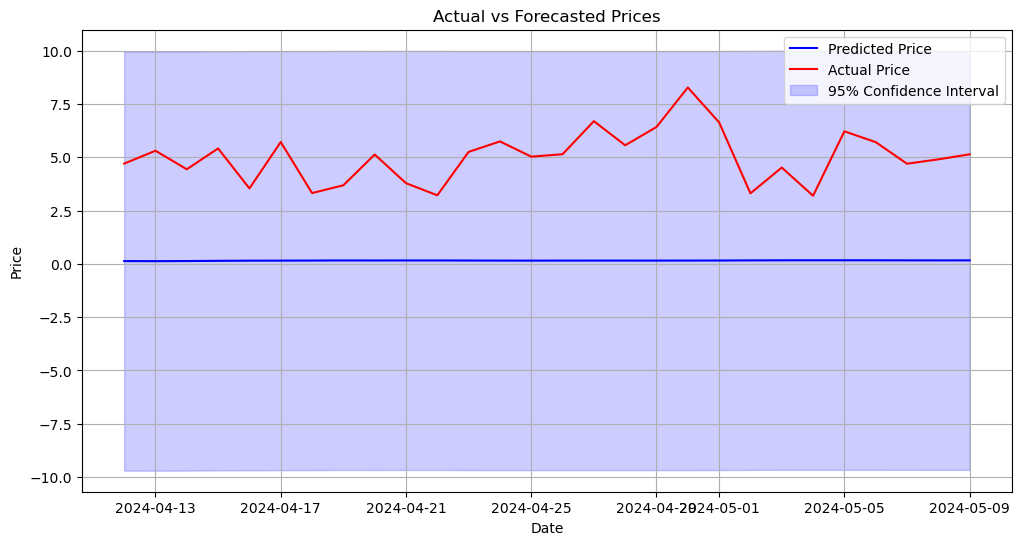

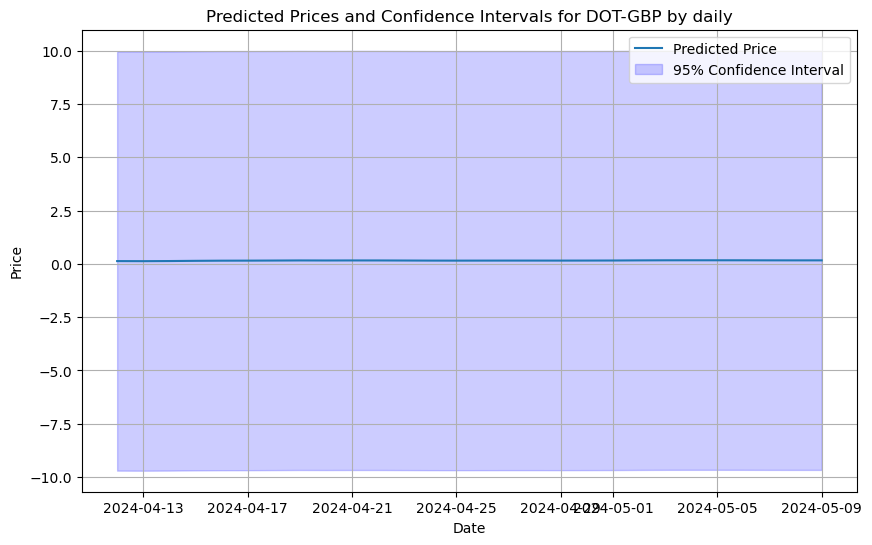

In [3]:
# doings
# Coin_1 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import joblib
import os
import tensorflow as tf

# Function to evaluate different models for the first coin price prediction
def evaluate_models_coin_1(selected_data):
    coin_name = selected_data.columns[0]  # Dynamically get the name of the first column
    # Add lagged features for 1 to 3 days
    for lag in range(1, 4):
        selected_data.loc[:, f'{coin_name}_lag_{lag}'] = selected_data[coin_name].shift(lag)

    # Drop rows with NaN values created due to shifting
    selected_data.dropna(inplace=True)

    # Features will be the lagged values, and the target will be the current price of the first coin
    features = [f'{coin_name}_lag_{lag}' for lag in range(1, 4)]
    X = selected_data[features]
    y = selected_data[coin_name]

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize dictionary to hold models
    models = {
        'GBR': GradientBoostingRegressor(),
        'SVR': SVR(),
        'XGB': XGBRegressor(),  # Alias for XGBoost
        'LSTM': Sequential([LSTM(units=50, input_shape=(X_train.shape[1], 1)), Dense(units=1)])
    }
    # Load pre-trained models for SVR, XGBoost, and Gradient Boosting
    for model_name in ['SVR', 'XGBoost', 'Gradient Boosting']:
        model_filename = f"Model_SELECTED_COIN_1/{model_name.lower().replace(' ', '_')}_model.pkl"
        if os.path.exists(model_filename):
            models[model_name] = joblib.load(model_filename)
        else:
            print(f"No pre-trained model found for {model_name}. Skipping...")

    # User input for selecting the model
    model_choice = input("Enter the model to use (SVR, XGB, GBR, LSTM): ").upper()

    # Initialize and train the selected model
    if model_choice in models:
        model = models[model_choice]
        if model_choice != 'LSTM':
            model.fit(X_train, y_train)
    elif model_choice == 'LSTM':
        model_filename = "Model_SELECTED_COIN_1/lstm_model.pkl"
        if os.path.exists(model_filename):
            model = tf.keras.models.load_model(model_filename)
            # Reshape the input data for LSTM model
            X_test_array = X_test.to_numpy().reshape(X_test.shape[0], X_test.shape[1], 1)
            predictions = model.predict(X_test_array).flatten()
        else:
            print("No pre-trained LSTM model found.")
            return None, None, None, None
    else:
        print("Invalid model choice. Please choose from SVR, XGB, GBR, or LSTM.")
        return None, None, None, None

    return model, selected_data, X_test, y_test

# Function to plot predictions and confidence intervals
def plot_predictions(model, selected_data, X_test, y_test):
    if model is not None:
        # User input for frequency and number of periods (weeks, months, or quarters)
        frequency = input("Enter the frequency (daily, weekly, monthly, quarterly): ").lower()
        num_periods = int(input("Enter the number of periods: "))

        # Make predictions for the specified number of periods
        coin_name = selected_data.columns[0]  # Dynamically retrieve the coin name
        features = [f'{coin_name}_lag_{lag}' for lag in range(1, 4)]
        X_array = selected_data[features].to_numpy()
        predictions = model.predict(X_array[-num_periods:])  # Predictions for the last 'num_periods' rows

        # Get the last date in the dataset
        last_date = selected_data.index[-1]

        # Generate periods for future predictions
        if frequency == 'daily':
            periods = pd.date_range(start=last_date, periods=num_periods, freq='D')
        elif frequency == 'weekly':
            periods = pd.date_range(start=last_date, periods=num_periods, freq='W')
        elif frequency == 'monthly':
            periods = pd.date_range(start=last_date, periods=num_periods, freq='M')
        elif frequency == 'quarterly':
            periods = pd.date_range(start=last_date, periods=num_periods, freq='Q')
        else:
            print("Invalid frequency. Please choose from 'daily', 'weekly', 'monthly', or 'quarterly'.")

        # Calculate mean squared error
        mse = mean_squared_error(y_test[-num_periods:], predictions)

        # Plot actual and forecasted prices with confidence intervals
        upper_bound = predictions + 1.96 * np.sqrt(mse)
        lower_bound = predictions - 1.96 * np.sqrt(mse)

        # Flatten arrays for fill_between
        upper_bound = upper_bound.flatten()
        lower_bound = lower_bound.flatten()

        # Print shapes for debugging
        print("Shapes:")
        print("predictions:", predictions.shape)
        print("upper_bound:", upper_bound.shape)
        print("lower_bound:", lower_bound.shape)

        # Call the function for plotting
        plot_actual_forecast_with_confidence(y_test[-num_periods:], predictions, periods, upper_bound, lower_bound)

        # Creating a time series plot with averages and confidence intervals
        plt.figure(figsize=(10, 6))
        plt.plot(periods, predictions, label='Predicted Price')
        plt.fill_between(periods, lower_bound, upper_bound, color='b', alpha=0.2, label='95% Confidence Interval')
        plt.title(f"Predicted Prices and Confidence Intervals for {coin_name} by {frequency}")
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.show()
# Plotting function for actual vs forecasted prices with confidence intervals
def plot_actual_forecast_with_confidence(actual, predictions, periods, upper_bound, lower_bound):
    plt.figure(figsize=(12, 6))
    plt.plot(periods, predictions, label='Predicted Price', color='blue')
    plt.plot(periods, actual, label='Actual Price', color='red')
    plt.fill_between(periods, lower_bound, upper_bound, color='blue', alpha=0.2, label='95% Confidence Interval')
    plt.title('Actual vs Forecasted Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(True)
    plt.legend()
    plt.show()


# Load the selected data from a CSV file
selected_data = pd.read_csv("Selected_coins.csv", index_col='Date')

# Evaluate the model and get the trained model, selected_data, X_test, and y_test
model, selected_data, X_test, y_test = evaluate_models_coin_1(selected_data)

# Plot predictions and confidence intervals
plot_predictions(model, selected_data, X_test, y_test)


Enter the model to use (SVR, XGB, GBR, LSTM):  svr
Enter the frequency (daily, weekly, monthly, quarterly):  monthly
Enter the number of periods:  16


Shapes:
predictions: (16,)
upper_bound: (16,)
lower_bound: (16,)


C:\Users\adedi\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


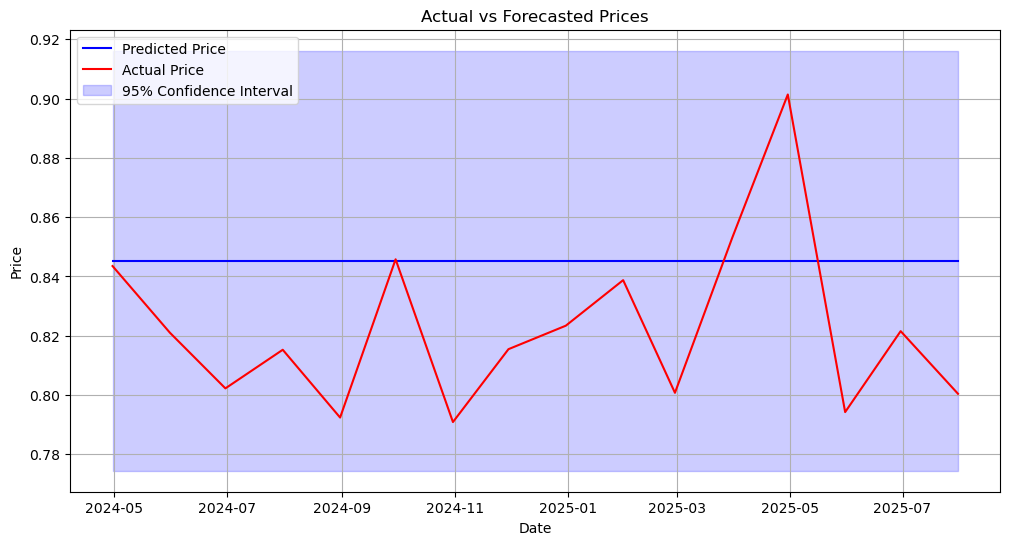

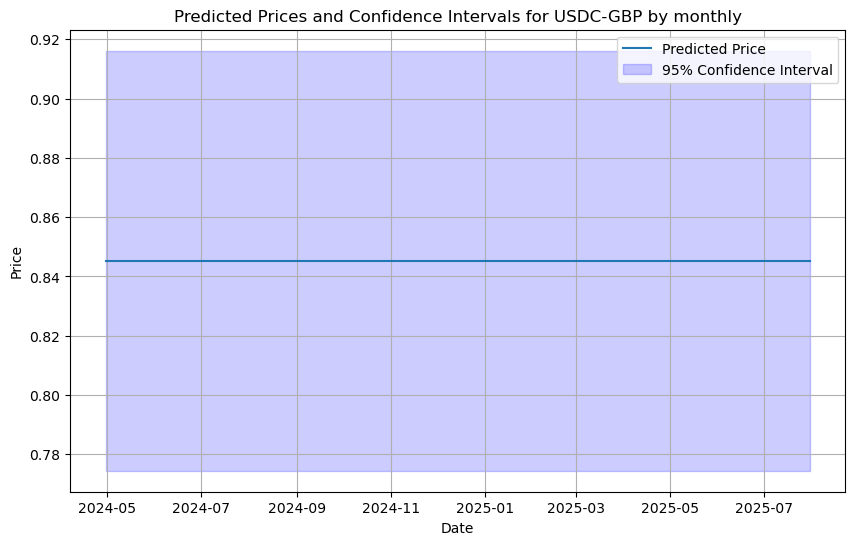

In [5]:
# doings


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import joblib
import os
import tensorflow as tf

# Function to evaluate different models for the first coin price prediction
def evaluate_models_coin_3(selected_data):
    coin_name = selected_data.columns[2]  # Dynamically get the name of the first column
    # Add lagged features for 1 to 3 days
    for lag in range(1, 4):
        selected_data.loc[:, f'{coin_name}_lag_{lag}'] = selected_data[coin_name].shift(lag)

    # Drop rows with NaN values created due to shifting
    selected_data.dropna(inplace=True)

    # Features will be the lagged values, and the target will be the current price of the first coin
    features = [f'{coin_name}_lag_{lag}' for lag in range(1, 4)]
    X = selected_data[features]
    y = selected_data[coin_name]

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize dictionary to hold models
    models = {
        'GBR': GradientBoostingRegressor(),
        'SVR': SVR(),
        'XGB': XGBRegressor(),  # Alias for XGBoost
        'LSTM': Sequential([LSTM(units=50, input_shape=(X_train.shape[1], 1)), Dense(units=1)])
    }
    # Load pre-trained models for SVR, XGBoost, and Gradient Boosting
    for model_name in ['SVR', 'XGBoost', 'Gradient Boosting']:
        model_filename = f"Model_SELECTED_COIN_3/{model_name.lower().replace(' ', '_')}_model.pkl"
        if os.path.exists(model_filename):
            models[model_name] = joblib.load(model_filename)
        else:
            print(f"No pre-trained model found for {model_name}. Skipping...")

    # User input for selecting the model
    model_choice = input("Enter the model to use (SVR, XGB, GBR, LSTM): ").upper()

    # Initialize and train the selected model
    if model_choice in models:
        model = models[model_choice]
        if model_choice != 'LSTM':
            model.fit(X_train, y_train)
    elif model_choice == 'LSTM':
        model_filename = "Model_SELECTED_COIN_3/lstm_model.pkl"
        if os.path.exists(model_filename):
            model = tf.keras.models.load_model(model_filename)
            # Reshape the input data for LSTM model
            X_test_array = X_test.to_numpy().reshape(X_test.shape[0], X_test.shape[1], 1)
            predictions = model.predict(X_test_array).flatten()
        else:
            print("No pre-trained LSTM model found.")
            return None, None, None, None
    else:
        print("Invalid model choice. Please choose from SVR, XGB, GBR, or LSTM.")
        return None, None, None, None

    return model, selected_data, X_test, y_test

# Function to plot predictions and confidence intervals
def plot_predictions(model, selected_data, X_test, y_test):
    if model is not None:
        # User input for frequency and number of periods (weeks, months, or quarters)
        frequency = input("Enter the frequency (daily, weekly, monthly, quarterly): ").lower()
        num_periods = int(input("Enter the number of periods: "))

        # Make predictions for the specified number of periods
        coin_name = selected_data.columns[2]  # Dynamically retrieve the coin name
        features = [f'{coin_name}_lag_{lag}' for lag in range(1, 4)]
        X_array = selected_data[features].to_numpy()
        predictions = model.predict(X_array[-num_periods:])  # Predictions for the last 'num_periods' rows

        # Get the last date in the dataset
        last_date = selected_data.index[-1]

        # Generate periods for future predictions
        if frequency == 'daily':
            periods = pd.date_range(start=last_date, periods=num_periods, freq='D')
        elif frequency == 'weekly':
            periods = pd.date_range(start=last_date, periods=num_periods, freq='W')
        elif frequency == 'monthly':
            periods = pd.date_range(start=last_date, periods=num_periods, freq='M')
        elif frequency == 'quarterly':
            periods = pd.date_range(start=last_date, periods=num_periods, freq='Q')
        else:
            print("Invalid frequency. Please choose from 'daily', 'weekly', 'monthly', or 'quarterly'.")

        # Calculate mean squared error
        mse = mean_squared_error(y_test[-num_periods:], predictions)

        # Plot actual and forecasted prices with confidence intervals
        upper_bound = predictions + 1.96 * np.sqrt(mse)
        lower_bound = predictions - 1.96 * np.sqrt(mse)

        # Flatten arrays for fill_between
        upper_bound = upper_bound.flatten()
        lower_bound = lower_bound.flatten()

        # Print shapes for debugging
        print("Shapes:")
        print("predictions:", predictions.shape)
        print("upper_bound:", upper_bound.shape)
        print("lower_bound:", lower_bound.shape)

        # Call the function for plotting
        plot_actual_forecast_with_confidence(y_test[-num_periods:], predictions, periods, upper_bound, lower_bound)

        # Creating a time series plot with averages and confidence intervals
        plt.figure(figsize=(10, 6))
        plt.plot(periods, predictions, label='Predicted Price')
        plt.fill_between(periods, lower_bound, upper_bound, color='b', alpha=0.2, label='95% Confidence Interval')
        plt.title(f"Predicted Prices and Confidence Intervals for {coin_name} by {frequency}")
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.show()

# Plotting function for actual vs forecasted prices with confidence intervals
def plot_actual_forecast_with_confidence(actual, predictions, periods, upper_bound, lower_bound):
    plt.figure(figsize=(12, 6))
    plt.plot(periods, predictions, label='Predicted Price', color='blue')
    plt.plot(periods, actual, label='Actual Price', color='red')
    plt.fill_between(periods, lower_bound, upper_bound, color='blue', alpha=0.2, label='95% Confidence Interval')
    plt.title('Actual vs Forecasted Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(True)
    plt.legend()
    plt.show()

# Load the selected data from a CSV file
selected_data = pd.read_csv("Selected_coins.csv", index_col='Date')

# Evaluate the model and get the trained model, selected_data, X_test, and y_test
model, selected_data, X_test, y_test = evaluate_models_coin_3(selected_data)

# Plot predictions and confidence intervals
plot_predictions(model, selected_data, X_test, y_test)


Enter the model to use (SVR, XGB, GBR, LSTM):  gbr
Enter the frequency (daily, weekly, monthly, quarterly):  quarterly
Enter the number of periods:  14


C:\Users\adedi\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


Shapes:
predictions: (14,)
upper_bound: (14,)
lower_bound: (14,)


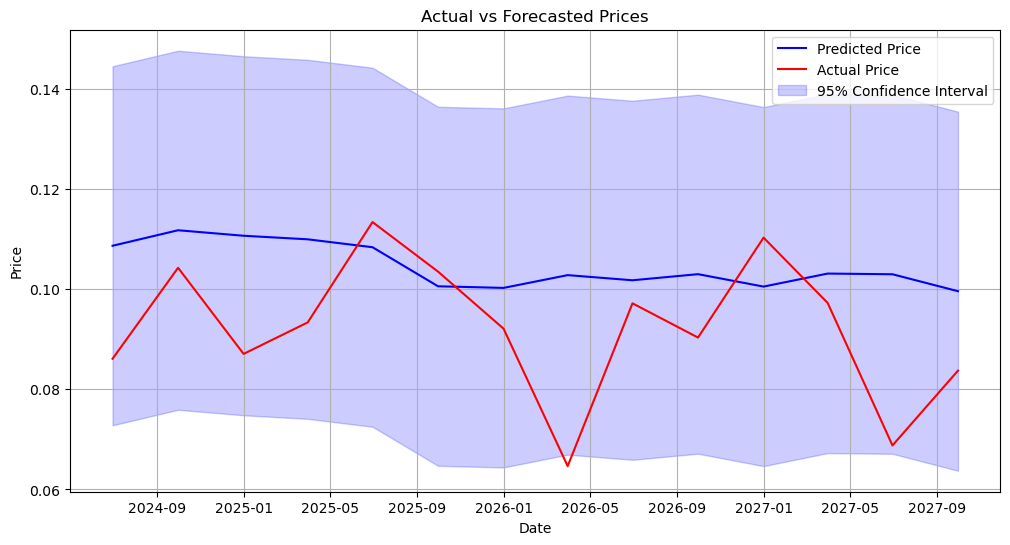

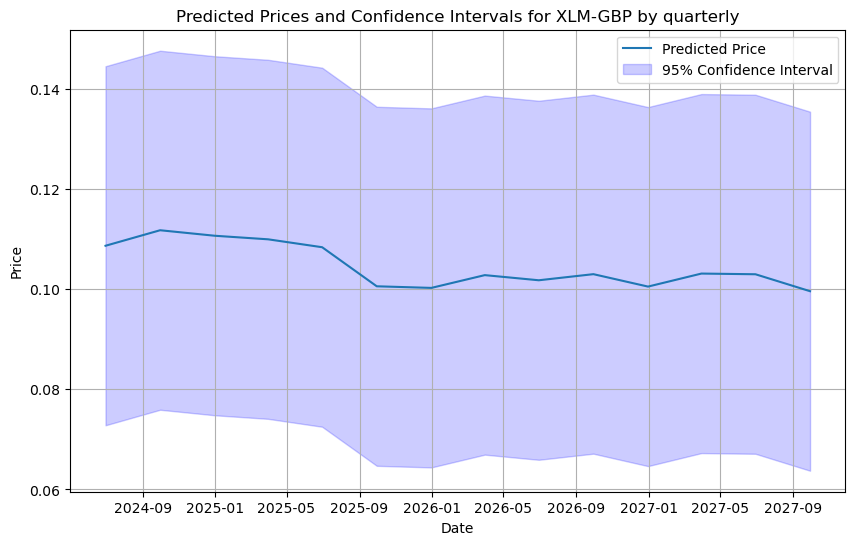

In [6]:
# doings


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import joblib
import os
import tensorflow as tf

# Function to evaluate different models for the first coin price prediction
def evaluate_models_coin_4(selected_data):
    coin_name = selected_data.columns[3]  # Dynamically get the name of the first column
    # Add lagged features for 1 to 3 days
    for lag in range(1, 4):
        selected_data.loc[:, f'{coin_name}_lag_{lag}'] = selected_data[coin_name].shift(lag)

    # Drop rows with NaN values created due to shifting
    selected_data.dropna(inplace=True)

    # Features will be the lagged values, and the target will be the current price of the first coin
    features = [f'{coin_name}_lag_{lag}' for lag in range(1, 4)]
    X = selected_data[features]
    y = selected_data[coin_name]

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize dictionary to hold models
    models = {
        'GBR': GradientBoostingRegressor(),
        'SVR': SVR(),
        'XGB': XGBRegressor(),  # Alias for XGBoost
        'LSTM': Sequential([LSTM(units=50, input_shape=(X_train.shape[1], 1)), Dense(units=1)])
    }
    # Load pre-trained models for SVR, XGBoost, and Gradient Boosting
    for model_name in ['SVR', 'XGBoost', 'Gradient Boosting']:
        model_filename = f"Model_SELECTED_COIN_4/{model_name.lower().replace(' ', '_')}_model.pkl"
        if os.path.exists(model_filename):
            models[model_name] = joblib.load(model_filename)
        else:
            print(f"No pre-trained model found for {model_name}. Skipping...")

    # User input for selecting the model
    model_choice = input("Enter the model to use (SVR, XGB, GBR, LSTM): ").upper()

    # Initialize and train the selected model
    if model_choice in models:
        model = models[model_choice]
        if model_choice != 'LSTM':
            model.fit(X_train, y_train)
    elif model_choice == 'LSTM':
        model_filename = "Model_SELECTED_COIN_4/lstm_model.pkl"
        if os.path.exists(model_filename):
            model = tf.keras.models.load_model(model_filename)
            # Reshape the input data for LSTM model
            X_test_array = X_test.to_numpy().reshape(X_test.shape[0], X_test.shape[1], 1)
            predictions = model.predict(X_test_array).flatten()
        else:
            print("No pre-trained LSTM model found.")
            return None, None, None, None
    else:
        print("Invalid model choice. Please choose from SVR, XGB, GBR, or LSTM.")
        return None, None, None, None

    return model, selected_data, X_test, y_test

# Function to plot predictions and confidence intervals
def plot_predictions(model, selected_data, X_test, y_test):
    if model is not None:
        # User input for frequency and number of periods (weeks, months, or quarters)
        frequency = input("Enter the frequency (daily, weekly, monthly, quarterly): ").lower()
        num_periods = int(input("Enter the number of periods: "))

        # Make predictions for the specified number of periods
        coin_name = selected_data.columns[3]  # Dynamically retrieve the coin name
        features = [f'{coin_name}_lag_{lag}' for lag in range(1, 4)]
        X_array = selected_data[features].to_numpy()
        predictions = model.predict(X_array[-num_periods:])  # Predictions for the last 'num_periods' rows

        # Get the last date in the dataset
        last_date = selected_data.index[-1]

        # Generate periods for future predictions
        if frequency == 'daily':
            periods = pd.date_range(start=last_date, periods=num_periods, freq='D')
        elif frequency == 'weekly':
            periods = pd.date_range(start=last_date, periods=num_periods, freq='W')
        elif frequency == 'monthly':
            periods = pd.date_range(start=last_date, periods=num_periods, freq='M')
        elif frequency == 'quarterly':
            periods = pd.date_range(start=last_date, periods=num_periods, freq='Q')
        else:
            print("Invalid frequency. Please choose from 'daily', 'weekly', 'monthly', or 'quarterly'.")

        # Calculate mean squared error
        mse = mean_squared_error(y_test[-num_periods:], predictions)

        # Plot actual and forecasted prices with confidence intervals
        upper_bound = predictions + 1.96 * np.sqrt(mse)
        lower_bound = predictions - 1.96 * np.sqrt(mse)

        # Flatten arrays for fill_between
        upper_bound = upper_bound.flatten()
        lower_bound = lower_bound.flatten()

        # Print shapes for debugging
        print("Shapes:")
        print("predictions:", predictions.shape)
        print("upper_bound:", upper_bound.shape)
        print("lower_bound:", lower_bound.shape)

        # Call the function for plotting
        plot_actual_forecast_with_confidence(y_test[-num_periods:], predictions, periods, upper_bound, lower_bound)

        # Creating a time series plot with averages and confidence intervals
        plt.figure(figsize=(10, 6))
        plt.plot(periods, predictions, label='Predicted Price')
        plt.fill_between(periods, lower_bound, upper_bound, color='b', alpha=0.2, label='95% Confidence Interval')
        plt.title(f"Predicted Prices and Confidence Intervals for {coin_name} by {frequency}")
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.show()



# Load the selected data from a CSV file
selected_data = pd.read_csv("Selected_coins.csv", index_col='Date')

# Evaluate the model and get the trained model, selected_data, X_test, and y_test
model, selected_data, X_test, y_test = evaluate_models_coin_4(selected_data)

# Plot predictions and confidence intervals
plot_predictions(model, selected_data, X_test, y_test)


In [9]:
selected_data = pd.read_csv("Selected_coins.csv", index_col='Date')
coin_list = selected_data.columns.tolist()

coin_list[0]

'DOT-GBP'

In [ ]:
# Function to evaluate different models for the first coin price prediction
def evaluate_models_coin_1(selected_data):
    coin_name = selected_data.columns[0]  # Dynamically get the name of the first column
    # Add lagged features for 1 to 3 days
    for lag in range(1, 4):
        selected_data.loc[:, f'{coin_name}_lag_{lag}'] = selected_data[coin_name].shift(lag)

    # Drop rows with NaN values created due to shifting
    selected_data.dropna(inplace=True)

    # Features will be the lagged values, and the target will be the current price of the first coin
    features = [f'{coin_name}_lag_{lag}' for lag in range(1, 4)]
    X = selected_data[features]
    y = selected_data[coin_name]

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize dictionary to hold models
    models = {
        'GBR': GradientBoostingRegressor(),
        'SVR': SVR(),
        'XGB': XGBRegressor(),  # Alias for XGBoost
        'LSTM': Sequential([LSTM(units=50, input_shape=(X_train.shape[1], 1)), Dense(units=1)])
    }
    # Load pre-trained models for SVR, XGBoost, and Gradient Boosting
    for model_name in ['SVR', 'XGBoost', 'Gradient Boosting']:
        model_filename = f"Model_SELECTED_COIN_1/{model_name.lower().replace(' ', '_')}_model.pkl"
        if os.path.exists(model_filename):
            models[model_name] = joblib.load(model_filename)
        else:
            print(f"No pre-trained model found for {model_name}. Skipping...")

    # User input for selecting the model
    model_choice = st.sidebar.selectbox("Choose the model you want to evaluate:", ['Gradient Boosting', 'SVR', 'XGBoost', 'LSTM'])

    # Initialize and train the selected model
    if model_choice in models:
        model = models[model_choice]
        if model_choice != 'LSTM':
            model.fit(X_train, y_train)
    elif model_choice == 'LSTM':
        model_filename = "Model_SELECTED_COIN_1/lstm_model.pkl"
        if os.path.exists(model_filename):
            model = tf.keras.models.load_model(model_filename)
            # Reshape the input data for LSTM model
            X_test_array = X_test.to_numpy().reshape(X_test.shape[0], X_test.shape[1], 1)
            predictions = model.predict(X_test_array).flatten()
        else:
            print("No pre-trained LSTM model found.")
            return None, None, None, None
    else:
        print("Invalid model choice. Please choose from SVR, XGB, GBR, or LSTM.")
        return None, None, None, None

    return model, selected_data, X_test, y_test

# Function to plot predictions and confidence intervals
def plot_predictions(model, selected_data, X_test, y_test):
    if model is not None:
        

        # Make predictions for the specified number of periods
        coin_name = selected_data.columns[0]  # Dynamically retrieve the coin name
        features = [f'{coin_name}_lag_{lag}' for lag in range(1, 4)]
        X_array = selected_data[features].to_numpy()
        predictions = model.predict(X_array[-num_periods:])  # Predictions for the last 'num_periods' rows

        # Get the last date in the dataset
        last_date = selected_data.index[-1]

        # Generate periods for future predictions
        if frequency == 'daily':
            periods = pd.date_range(start=last_date, periods=num_periods, freq='D')
        elif frequency == 'weekly':
            periods = pd.date_range(start=last_date, periods=num_periods, freq='W')
        elif frequency == 'monthly':
            periods = pd.date_range(start=last_date, periods=num_periods, freq='M')
        elif frequency == 'quarterly':
            periods = pd.date_range(start=last_date, periods=num_periods, freq='Q')
        else:
            print("Invalid frequency. Please choose from 'daily', 'weekly', 'monthly', or 'quarterly'.")

        # Calculate mean squared error
        mse = mean_squared_error(y_test[-num_periods:], predictions)

        # Plot actual and forecasted prices with confidence intervals
        upper_bound = predictions + 1.96 * np.sqrt(mse)
        lower_bound = predictions - 1.96 * np.sqrt(mse)

        # Flatten arrays for fill_between
        upper_bound = upper_bound.flatten()
        lower_bound = lower_bound.flatten()

        # Print shapes for debugging
        print("Shapes:")
        print("predictions:", predictions.shape)
        print("upper_bound:", upper_bound.shape)
        print("lower_bound:", lower_bound.shape)

        # Call the function for plotting
        plot_actual_forecast_with_confidence(y_test[-num_periods:], predictions, periods, upper_bound, lower_bound)

        # Creating a time series plot with averages and confidence intervals
        plt.figure(figsize=(10, 6))
        plt.plot(periods, predictions, label='Predicted Price')
        plt.fill_between(periods, lower_bound, upper_bound, color='b', alpha=0.2, label='95% Confidence Interval')
        plt.title(f"Predicted Prices and Confidence Intervals for {coin_name} by {frequency}")
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.show()
